In [4]:
!pip install Augmentor

In [5]:
# Required Libraries
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import pathlib
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import Augmentor
from scipy.stats import mode
import os


2024-04-29 12:27:15.961266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 12:27:15.961406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 12:27:16.126461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Data augmentation
p = Augmentor.Pipeline("/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2", output_directory="/kaggle/working/augmented")
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(12000)

Initialised with 8000 image(s) found.
Output directory set to /kaggle/working/augmented.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x576 at 0x7A2C18EA3B20>: 100%|██████████| 12000/12000 [07:32<00:00, 26.53 Samples/s]  


In [7]:
# Data preparation
data_dir = pathlib.Path('/kaggle/working/augmented')
img_height = 224
img_width = 224

In [8]:
# Data Preparation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = normalized_train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)



Found 36000 files belonging to 8 classes.
Using 28800 files for training.
Found 36000 files belonging to 8 classes.
Using 7200 files for validation.


In [9]:
# Model 1: InceptionV3
base_model1 = InceptionV3(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model1.layers[:10]:
    layer.trainable = False

x1 = GlobalAveragePooling2D()(base_model1.output)
x1 = Dense(512, activation='relu')(x1)
x1 = Dropout(0.4)(x1)
predictions1 = Dense(8, activation='softmax')(x1)
model1 = Model(inputs=base_model1.input, outputs=predictions1)


# Model 2: VGG16
base_model2 = VGG16(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model2.layers[:15]:
    layer.trainable = False

x2 = GlobalAveragePooling2D()(base_model2.output)
x2 = Dense(256, activation='relu')(x2)
x2 = Dropout(0.5)(x2)  # Increased dropout rate
predictions2 = Dense(8, activation='softmax')(x2)
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Model 3: ResNet50
base_model3 = ResNet50(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model3.layers[:15]:
    layer.trainable = False

x3 = GlobalAveragePooling2D()(base_model3.output)
x3 = Dense(256, activation='relu')(x3)
x3 = Dropout(0.5)(x3)  # Increased dropout rate
predictions3 = Dense(8, activation='softmax')(x3)
model3 = Model(inputs=base_model3.input, outputs=predictions3)

# Model 4: MobileNetV2
base_model4 = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model4.layers[:15]:
    layer.trainable = False

x4 = GlobalAveragePooling2D()(base_model4.output)
x4 = Dense(256, activation='relu')(x4)
x4 = Dropout(0.5)(x4)  # Increased dropout rate
predictions4 = Dense(8, activation='softmax')(x4)
model4 = Model(inputs=base_model4.input, outputs=predictions4)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Checkpoint to save best model per epoch
model1_filepath = "/kaggle/working/model1-{epoch:02d}-{val_accuracy:.4f}.keras"
model2_filepath = "/kaggle/working/model2-{epoch:02d}-{val_accuracy:.4f}.keras"
model3_filepath = "/kaggle/working/model3-{epoch:02d}-{val_accuracy:.4f}.keras"
model4_filepath = "/kaggle/working/model4-{epoch:02d}-{val_accuracy:.4f}.keras"

checkpoint1 = ModelCheckpoint(
    filepath=model1_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint2 = ModelCheckpoint(
    filepath=model2_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint3 = ModelCheckpoint(
    filepath=model3_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint4 = ModelCheckpoint(
    filepath=model4_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [11]:
# Define input shape
model_input = Input(shape=(img_height, img_width, 3))

# Get outputs from each model
output1 = model1(model_input)
output2 = model2(model_input)
output3 = model3(model_input)
output4 = model4(model_input)

In [12]:
# Compile individual models
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model4.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

In [13]:
# Train each individual model
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint1]
)

Epoch 1/10


I0000 00:00:1714394341.299184     147 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714394341.415151     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7673 - loss: 0.6414

W0000 00:00:1714394529.606372     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.79500, saving model to /kaggle/working/model1-01-0.7950.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 349s 228ms/step - accuracy: 0.7674 - loss: 0.6412 - val_accuracy: 0.7950 - val_loss: 0.5401
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8959 - loss: 0.2779
Epoch 2: val_accuracy improved from 0.79500 to 0.84417, saving model to /kaggle/working/model1-02-0.8442.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 199s 221ms/step - accuracy: 0.8959 - loss: 0.2779 - val_accuracy: 0.8442 - val_loss: 0.5125
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9275 - loss: 0.2001
Epoch 3: val_accuracy improved from 0.84417 to 0.85472, saving model to /kaggle/working/model1-03-0.8547.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 199s 221ms/step - accuracy: 0.9275 - loss: 0.2001 - val_accuracy: 0.8547 - val_loss: 0.4154
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9417 - loss: 0.1637
Epoch 4: val_accuracy improved from 0.8547

In [14]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint2]
)

Epoch 1/10
  1/900 ━━━━━━━━━━━━━━━━━━━━ 9:34:55 38s/step - accuracy: 0.1562 - loss: 2.3452

W0000 00:00:1714396365.409251     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3907 - loss: 1.3657

W0000 00:00:1714396505.235411     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.81153, saving model to /kaggle/working/model2-01-0.8115.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 209s 190ms/step - accuracy: 0.3909 - loss: 1.3653 - val_accuracy: 0.8115 - val_loss: 0.4397
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8392 - loss: 0.4192
Epoch 2: val_accuracy improved from 0.81153 to 0.88319, saving model to /kaggle/working/model2-02-0.8832.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 171s 190ms/step - accuracy: 0.8392 - loss: 0.4192 - val_accuracy: 0.8832 - val_loss: 0.3006
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9019 - loss: 0.2563
Epoch 3: val_accuracy improved from 0.88319 to 0.92556, saving model to /kaggle/working/model2-03-0.9256.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 172s 191ms/step - accuracy: 0.9019 - loss: 0.2563 - val_accuracy: 0.9256 - val_loss: 0.1914
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9283 - loss: 0.1896
Epoch 4: val_accuracy improved from 0.9255

In [15]:
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint3]
)

Epoch 1/10


W0000 00:00:1714398145.462381     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6390 - loss: 0.9251

W0000 00:00:1714398388.812923     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.62597, saving model to /kaggle/working/model3-01-0.6260.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 337s 292ms/step - accuracy: 0.6391 - loss: 0.9248 - val_accuracy: 0.6260 - val_loss: 1.0431
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8348 - loss: 0.4237
Epoch 2: val_accuracy improved from 0.62597 to 0.80625, saving model to /kaggle/working/model3-02-0.8062.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 274s 287ms/step - accuracy: 0.8348 - loss: 0.4237 - val_accuracy: 0.8062 - val_loss: 0.7117
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8783 - loss: 0.3163
Epoch 3: val_accuracy improved from 0.80625 to 0.89875, saving model to /kaggle/working/model3-03-0.8988.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 258s 286ms/step - accuracy: 0.8783 - loss: 0.3163 - val_accuracy: 0.8988 - val_loss: 0.2868
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9076 - loss: 0.2485
Epoch 4: val_accuracy improved from 0.8987

In [16]:
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[checkpoint4]
)

Epoch 1/15
  2/900 ━━━━━━━━━━━━━━━━━━━━ 1:41 113ms/step - accuracy: 0.1641 - loss: 2.5534  

W0000 00:00:1714400793.426011     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7796 - loss: 0.6228

W0000 00:00:1714400869.543589     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.25875, saving model to /kaggle/working/model4-01-0.2587.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 137s 92ms/step - accuracy: 0.7797 - loss: 0.6226 - val_accuracy: 0.2587 - val_loss: 8.7278
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9014 - loss: 0.2829
Epoch 2: val_accuracy improved from 0.25875 to 0.50833, saving model to /kaggle/working/model4-02-0.5083.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.9014 - loss: 0.2829 - val_accuracy: 0.5083 - val_loss: 5.0005
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9224 - loss: 0.2130
Epoch 3: val_accuracy improved from 0.50833 to 0.72597, saving model to /kaggle/working/model4-03-0.7260.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.9224 - loss: 0.2130 - val_accuracy: 0.7260 - val_loss: 1.8425
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9342 - loss: 0.1875
Epoch 4: val_accuracy improved from 0.72597 to 0.7

In [17]:
# Get predictions from individual models for the validation set
predictions1 = model1.predict(val_ds)
predictions2 = model2.predict(val_ds)
predictions3 = model3.predict(val_ds)
predictions4 = model4.predict(val_ds)



  3/225 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step

W0000 00:00:1714401989.538902     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step
  2/225 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step 

W0000 00:00:1714402003.280059     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 140ms/step
  3/225 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step

W0000 00:00:1714402038.317370     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step
  7/225 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step

W0000 00:00:1714402059.117758     144 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


In [18]:
# Define accuracies for each model
accuracy1 = history1.history['accuracy'][-1]
accuracy2 = history2.history['accuracy'][-1]
accuracy3 = history3.history['accuracy'][-1]
accuracy4 = history4.history['accuracy'][-1]

In [19]:
accuracy1 = model1.evaluate(val_ds)[1]
accuracy2 = model2.evaluate(val_ds)[1]
accuracy3 = model3.evaluate(val_ds)[1]
accuracy4 = model4.evaluate(val_ds)[1]

print("Model 1 Accuracy:", accuracy1)
print("Model 2 Accuracy:", accuracy2)
print("Model 3 Accuracy:", accuracy3)
print("Model 4 Accuracy:", accuracy4)

225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.9372 - loss: 0.1932
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.9443 - loss: 0.2158
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.9500 - loss: 0.1653
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8861 - loss: 0.6849
Model 1 Accuracy: 0.9351388812065125
Model 2 Accuracy: 0.9458333253860474
Model 3 Accuracy: 0.9473611116409302
Model 4 Accuracy: 0.8880555629730225


In [20]:
# Calculate weights based on individual accuracies
total_accuracy = accuracy1 + accuracy2 + accuracy3 + accuracy4
weight1 = accuracy1 / total_accuracy
weight2 = accuracy2 / total_accuracy
weight3 = accuracy3 / total_accuracy
weight4 = accuracy4 / total_accuracy

In [21]:
# Combine predictions with weights
combined_predictions = (weight1 * predictions1) + (weight2 * predictions2) + (weight3 * predictions3) + (weight4 * predictions4)

In [22]:
# Get true labels from the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)


In [23]:

ensemble_predictions = np.argmax(combined_predictions, axis=1)
# Calculate ensemble accuracy
ensemble_accuracy = np.mean(np.equal(ensemble_predictions, true_labels))
print("Ensemble Accuracy:", ensemble_accuracy)


Ensemble Accuracy: 0.9815277777777778


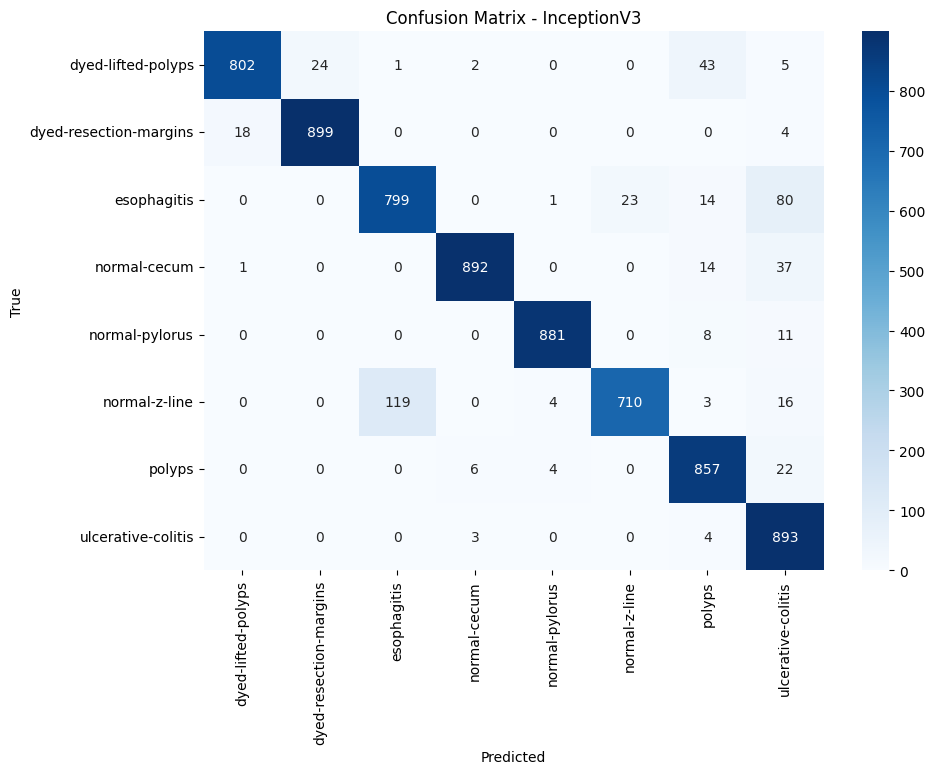

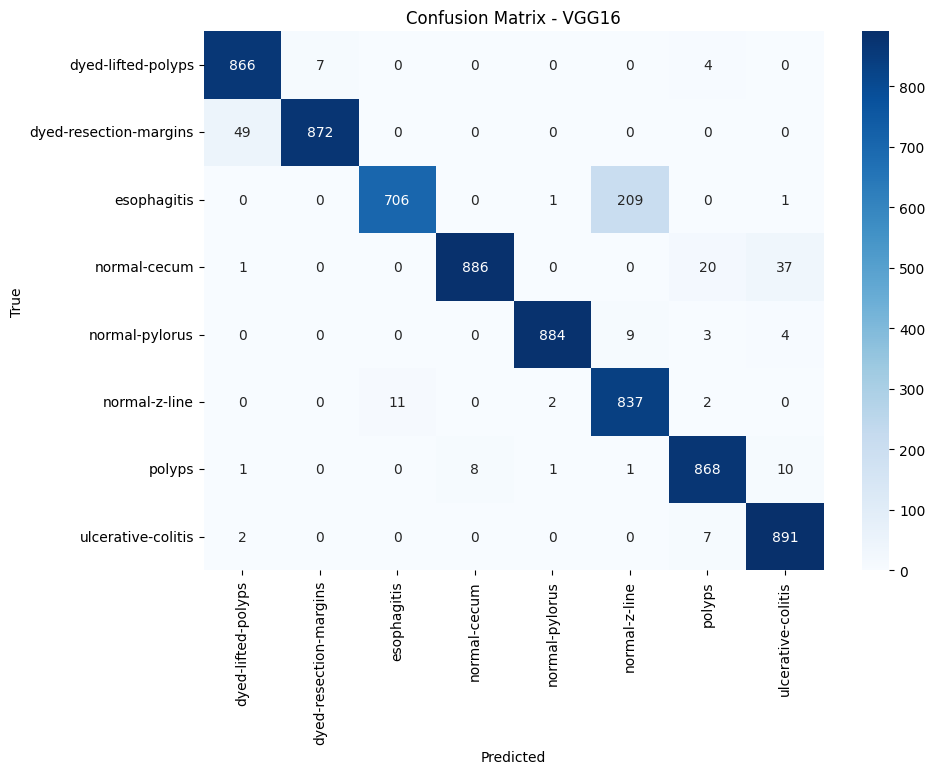

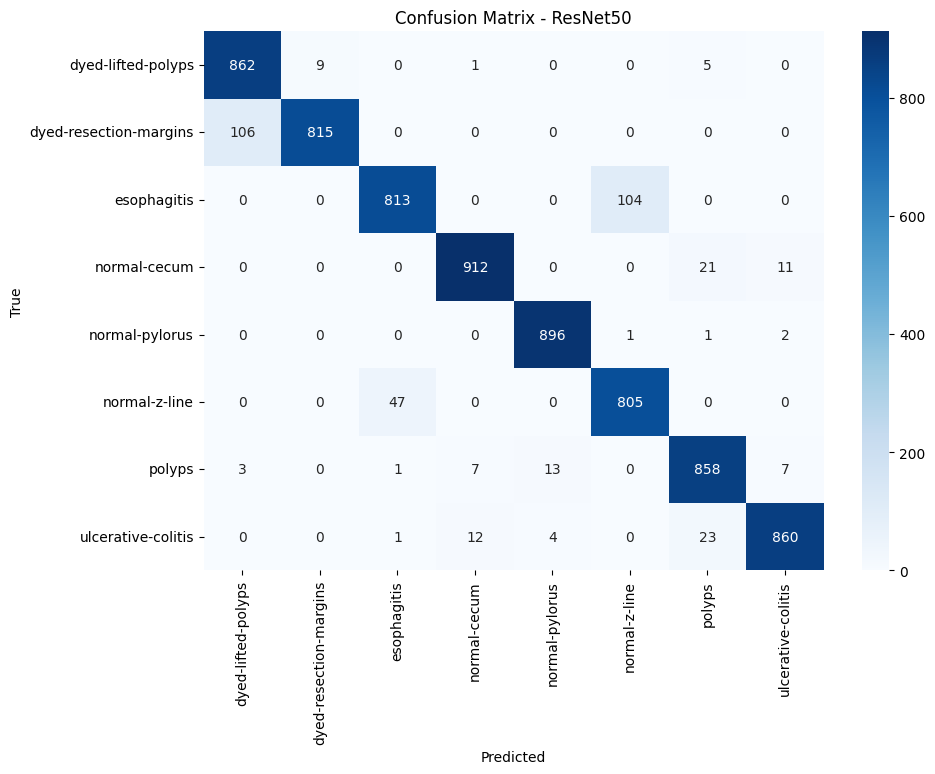

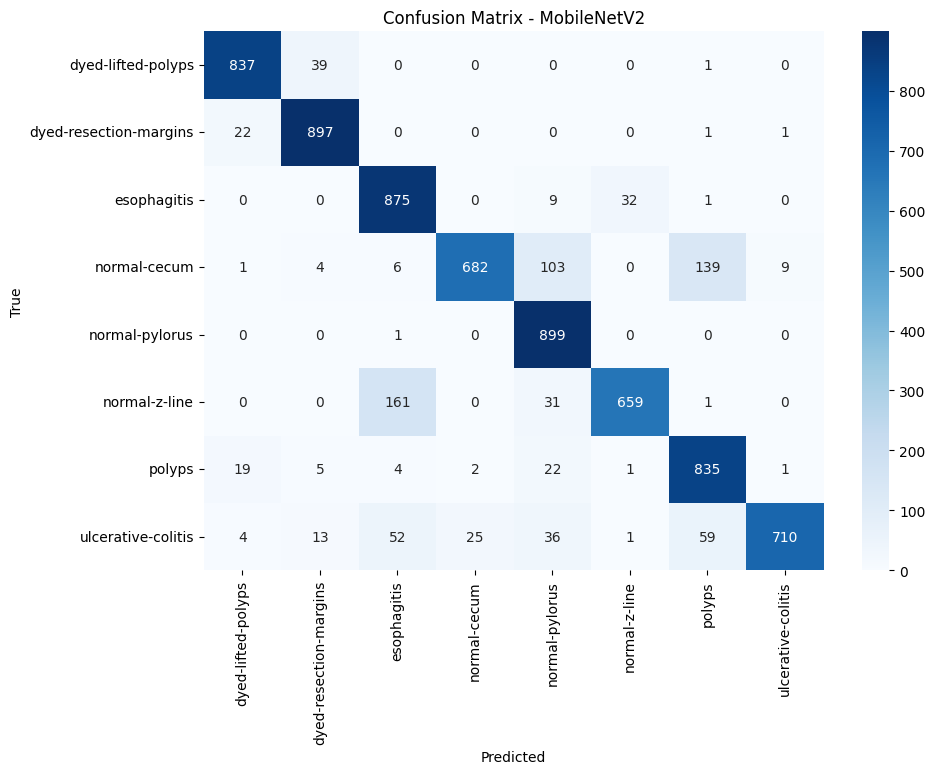

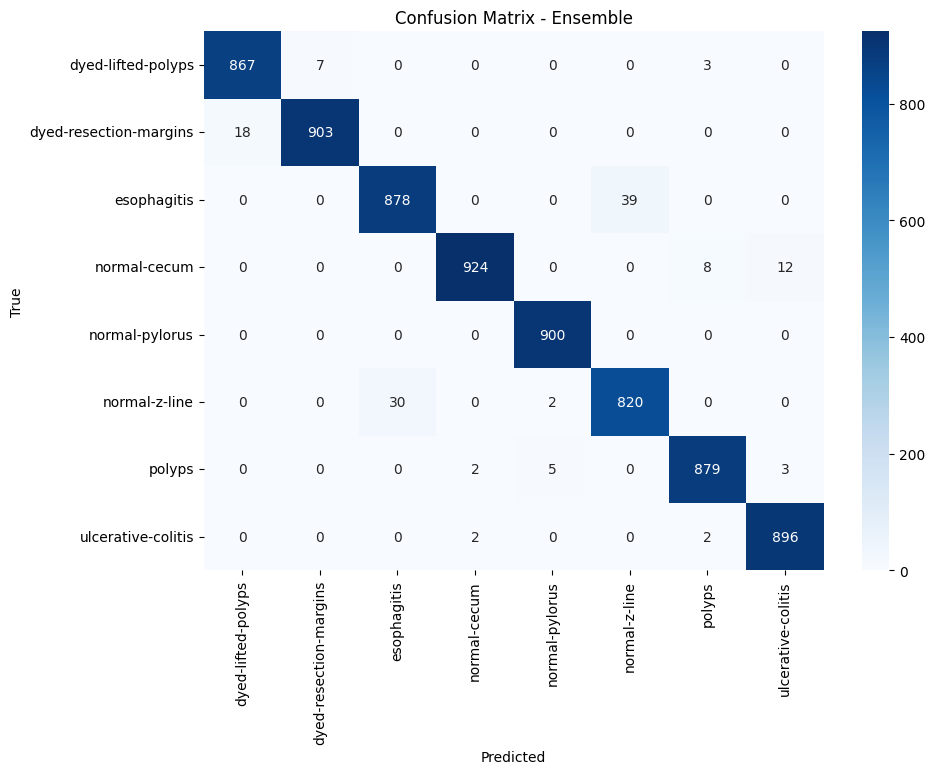

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
labels = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum',
          'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

# Define function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Confusion matrix for Model 1 (InceptionV3)
model1_predictions = np.argmax(predictions1, axis=1)
plot_confusion_matrix(true_labels, model1_predictions, 'Confusion Matrix - InceptionV3')

# Confusion matrix for Model 2 (VGG16)
model2_predictions = np.argmax(predictions2, axis=1)
plot_confusion_matrix(true_labels, model2_predictions, 'Confusion Matrix - VGG16')

# Confusion matrix for Model 3 (ResNet50)
model3_predictions = np.argmax(predictions3, axis=1)
plot_confusion_matrix(true_labels, model3_predictions, 'Confusion Matrix - ResNet50')

# Confusion matrix for Model 4 (MobileNetV2)
model4_predictions = np.argmax(predictions4, axis=1)
plot_confusion_matrix(true_labels, model4_predictions, 'Confusion Matrix - MobileNetV2')

# Confusion matrix for Ensemble model
plot_confusion_matrix(true_labels, ensemble_predictions, 'Confusion Matrix - Ensemble')
